In [25]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.io.fits as fits
import skimage.io as io
import tifffile as tiff

In [40]:
def loadData(path,time) :
    data = {}
    data["h2o"]     = fits.getdata('{}/h2o_{}s.fits'.format(path,time))
#    data["empty"]   = fits.getdata('{}/empty_{}s.fits'.format(path,time))
    data["ob"]      = fits.getdata('{}/ob_{}s_00001.fits'.format(path,time))
    data["dc"]      = fits.getdata('{}/dc_{}s_00001.fits'.format(path,time))
    data["bbob"]    = fits.getdata('{}/bb_ob_{}s.fits'.format(path,time))
    data["bbh2o"]   = fits.getdata('{}/bb_h2o_{}s.fits'.format(path,time))
#    data["bbempty"] = fits.getdata('{}/bb_empty_{}s.fits'.format(path,time))
    
    return data

(0.0, 1.0, 0.0, 1.0)

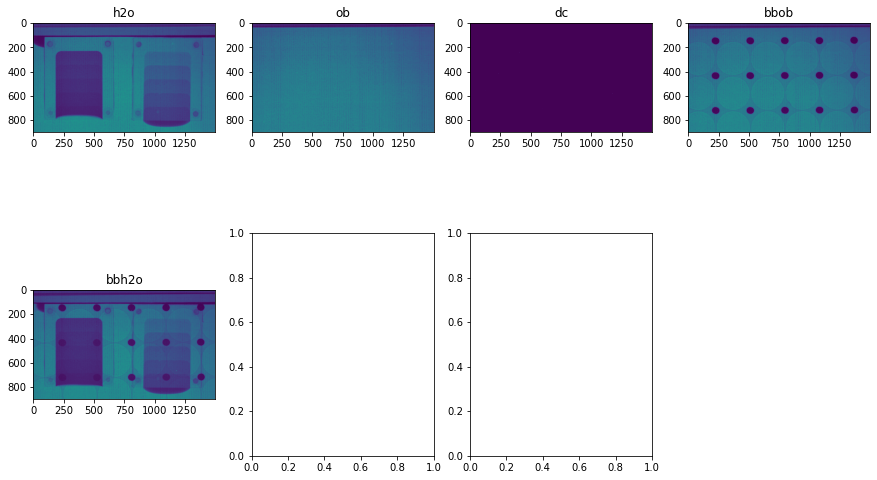

In [41]:
t=120
data=loadData('/Users/Shared/data/P20212345/ICON/02_rawdata/01_h2o',t)

fig, ax = plt.subplots(2,4,figsize=(15,9))
ax=ax.ravel()

for lbl,axis in zip(data,ax) :
    img=data[lbl][0:900,400:1900]
    axis.imshow(img)
    axis.set_title(lbl)
    tiff.imsave(file="../data/stepwedge/exp{}s_{}.tif".format(t,lbl),data=img[::-1])
    
ax[-1].axis('off')

In [26]:
help(tiff.imsave)

Help on function imwrite in module tifffile.tifffile:

imwrite(file, data=None, shape=None, dtype=None, **kwargs)
    Write numpy array to TIFF file.
    
    Refer to the TiffWriter class and its write function for documentation.
    
    A BigTIFF file is created if the data's size is larger than 4 GB minus
    32 MB (for metadata), and 'bigtiff' is not specified, and 'imagej' or
    'truncate' are not enabled.
    
    Parameters
    ----------
    file : str, path-like, or binary stream
        File name or writable binary stream, such as an open file or BytesIO.
    data : array-like
        Input image. The last dimensions are assumed to be image depth,
        length, width, and samples.
        If None, an empty array of the specified shape and dtype is
        saved to file.
        Unless 'byteorder' is specified in 'kwargs', the TIFF file byte order
        is determined from the data's dtype or the dtype argument.
    shape : tuple
        If 'data' is None, shape of an emp